# Preamble

In [ ]:
# Useful packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sage
import seaborn as sns
import tqdm
from utils import make_led, make_led_sample

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split

/home/gaeta/.sklearn-env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Model and data

In [8]:
# Make a dataset
X, y = make_led_sample(n_samples=1100)
# Split train test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1000)
# Get the size of dataset
n_features = X_train.shape[1]

In [9]:
# Compute MDI for varying K
n_estimators = 100
MDI = pd.DataFrame(
    index=["x1", "x2", "x3", "x4", "x5", "x6", "x7"],
)
for K in range(1, n_features + 1):
    model = ExtraTreesClassifier(
        n_estimators=n_estimators,
        max_features=K,
        max_depth=None,
        min_samples_split=2,
        criterion="entropy",
        verbose=0,
        n_jobs=1,
        random_state=K,
    )
    model.fit(X_train, y_train)
    MDI.loc[:, f"{K}"] = model.feature_importances_

In [10]:
UMDI = pd.DataFrame(
    index=["x1", "x2", "x3", "x4", "x5", "x6", "x7"],
)
for K in range(1, n_features + 1):
    model = ExtraTreesClassifier(
        n_estimators=n_estimators,
        max_features=K,
        max_depth=None,
        min_samples_split=2,
        criterion="log_loss",
        verbose=0,
        n_jobs=1,
        oob_score=True,
        bootstrap=True,
        random_state=K,
    )
    model.fit(X_train, y_train)
    UMDI.loc[:, f"{K}"] = (
        model._compute_unbiased_feature_importance_and_oob_predictions(
            X_train, y_train
        )[0]
    )

In [11]:
SAGE_train = pd.DataFrame(
    index=["x1", "x2", "x3", "x4", "x5", "x6", "x7"],
)
for K in range(1, n_features + 1):
    model = ExtraTreesClassifier(
        n_estimators=n_estimators,
        max_features=K,
        max_depth=None,
        min_samples_split=2,
        criterion="entropy",
        verbose=0,
        n_jobs=1,
        random_state=K,
    )
    model.fit(X_train, y_train)
    imputer = sage.MarginalImputer(model, X_train)
    estimator = sage.PermutationEstimator(
        imputer, "cross entropy", n_jobs=1, random_state=K
    )
    sage_values = estimator(X_train, y_train).values
    SAGE_train.loc[:, f"{K}"] = sage_values / sage_values.sum()

100%|██████████| 1/1 [00:04<00:00,  4.69s/it]     


In [12]:
SAGE_test = pd.DataFrame(
    index=["x1", "x2", "x3", "x4", "x5", "x6", "x7"],
)
for K in range(1, n_features + 1):
    model = ExtraTreesClassifier(
        n_estimators=n_estimators,
        max_features=K,
        max_depth=None,
        min_samples_split=2,
        criterion="entropy",
        verbose=0,
        n_jobs=1,
        random_state=K,
    )
    model.fit(X_train, y_train)
    imputer = sage.MarginalImputer(model, X_train)
    estimator = sage.PermutationEstimator(
        imputer, "cross entropy", n_jobs=1, random_state=K
    )
    sage_values = estimator(X_test, y_test).values
    SAGE_test.loc[:, f"{K}"] = sage_values / sage_values.sum()

100%|██████████| 1/1 [00:04<00:00,  4.11s/it]     


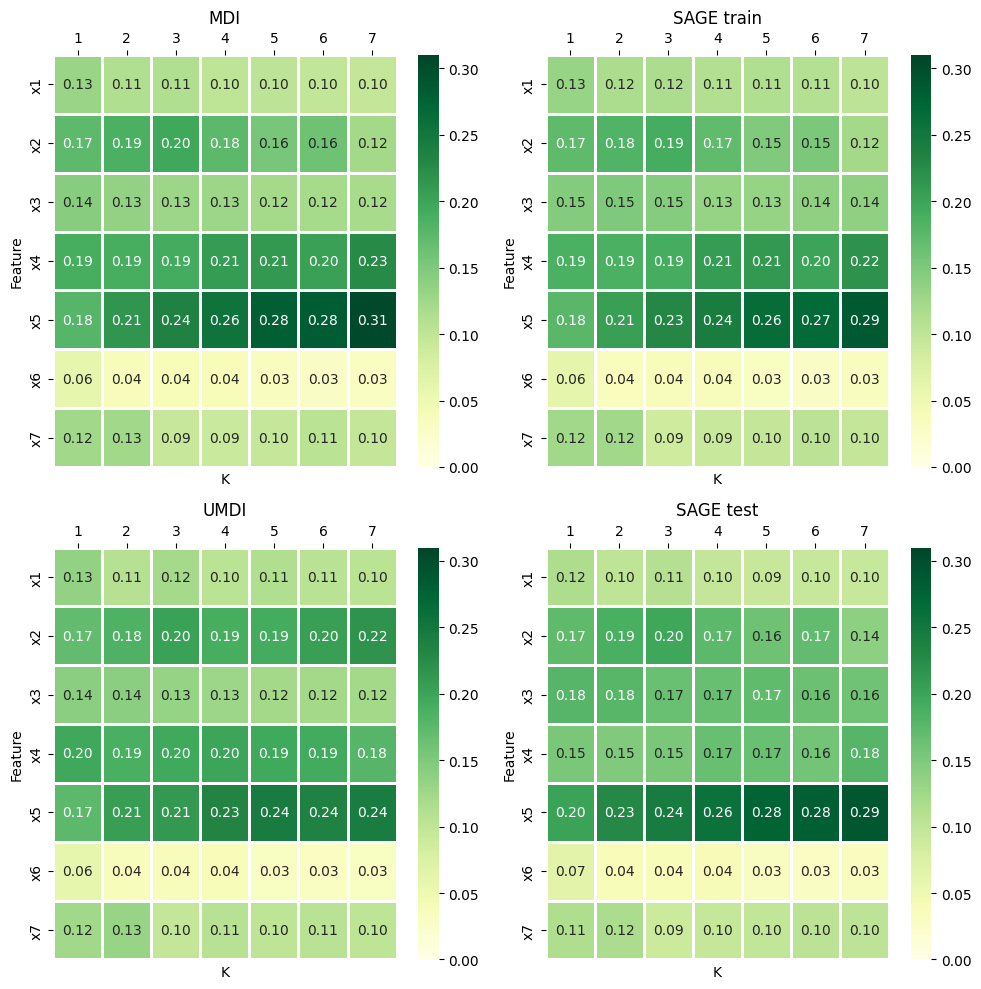

In [13]:
# Plot the heatmaps
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

sns.heatmap(
    MDI,
    annot=True,
    cmap="YlGn",
    fmt=".2f",
    linewidths=1,
    ax=axes[0, 0],
    vmin=0,
    vmax=0.31,
)
axes[0, 0].xaxis.tick_top()
axes[0, 0].set_xlabel("K")
axes[0, 0].set_ylabel("Feature")
axes[0, 0].set_title("MDI")

sns.heatmap(
    SAGE_train,
    annot=True,
    cmap="YlGn",
    fmt=".2f",
    linewidths=1,
    ax=axes[0, 1],
    vmin=0,
    vmax=0.31,
)
axes[0, 1].xaxis.tick_top()
axes[0, 1].set_xlabel("K")
axes[0, 1].set_ylabel("Feature")
axes[0, 1].set_title("SAGE train")


sns.heatmap(
    UMDI,
    annot=True,
    cmap="YlGn",
    fmt=".2f",
    linewidths=1,
    ax=axes[1, 0],
    vmin=0,
    vmax=0.31,
)
axes[1, 0].xaxis.tick_top()
axes[1, 0].set_xlabel("K")
axes[1, 0].set_ylabel("Feature")
axes[1, 0].set_title("UMDI")


sns.heatmap(
    SAGE_test,
    annot=True,
    cmap="YlGn",
    fmt=".2f",
    linewidths=1,
    ax=axes[1, 1],
    vmin=0,
    vmax=0.31,
)
axes[1, 1].xaxis.tick_top()
axes[1, 1].set_xlabel("K")
axes[1, 1].set_ylabel("Feature")
axes[1, 1].set_title("SAGE test")

plt.tight_layout()
plt.show()